# Model Deep Learning MLP (PyTorch dan TensorFlow) untuk Klasifikasi

## 1. Import Library Dasar

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import io
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

## 2. Import Library PyTorch

In [2]:
# Import library PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## 3. Import Library TensorFlow

In [3]:
# Import library TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

## 4. Persiapan Data

In [4]:
# Baca dataset dari URL GitHub
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/02.%20Deep%20Learning/Dataset/compressed_data.csv.gz"
response = requests.get(url)
with gzip.GzipFile(fileobj=io.BytesIO(response.content)) as f:
    df = pd.read_csv(f)

# Tampilkan informasi dataset
print("Informasi Dataset:")
print(df.info())
print("\nSampel Dataset:")
print(df.head())
print("\nDistribusi kelas target (Cover_Type):")
print(df['Cover_Type'].value_counts())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Soil_Type1                       

## 5. Preprocessing Data

In [5]:
# Pisahkan fitur dan target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

# Label encoding untuk target jika diperlukan
num_classes = len(y.unique())
print(f"\nJumlah kelas unik pada target: {num_classes}")

# Preprocessing: Standard Scaling untuk normalisasi data fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data menjadi data latih dan data uji (70:30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

print(f"Ukuran data latih: {X_train.shape}, {y_train.shape}")
print(f"Ukuran data uji: {X_test.shape}, {y_test.shape}")


Jumlah kelas unik pada target: 7
Ukuran data latih: (406708, 54), (406708,)
Ukuran data uji: (174304, 54), (174304,)


## 6. Fungsi Metrik Evaluasi

In [6]:
def calculate_metrics(y_true, y_pred, y_pred_proba, model_name):
    # Akurasi
    accuracy = accuracy_score(y_true, y_pred)

    # Presisi, Recall, dan F1-Score per kelas dan rata-rata
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Classification report
    report = classification_report(y_true, y_pred)

    # ROC Curve dan AUC untuk klasifikasi multi-kelas (One-vs-Rest)
    # Untuk multi-class, kita menggunakan pendekatan One-vs-Rest
    n_classes = len(np.unique(y_true))

    # Prepare untuk one-hot encoding y_true
    y_true_bin = np.zeros((len(y_true), n_classes))
    for i, val in enumerate(y_true):
        y_true_bin[i, val-1] = 1  # -1 karena kelas dimulai dari 1

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Rata-rata AUC
    avg_auc = sum(roc_auc.values()) / len(roc_auc)

    print(f"\nMatriks Evaluasi untuk model {model_name}:")
    print(f"Akurasi: {accuracy:.4f}")
    print(f"Presisi (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"AUC (rata-rata): {avg_auc:.4f}")
    print("\nClassification Report:")
    print(report)

    return accuracy, precision, recall, f1, avg_auc, fpr, tpr, roc_auc

# Model PyTorch

## 7. PyTorch - Definisi Model

In [7]:
class MLPPyTorch(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPPyTorch, self).__init__()
        # Arsitektur MLP dengan 3 hidden layer
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),    # Input layer -> Hidden layer 1
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Dropout(0.2),               # Dropout untuk mencegah overfitting
            nn.Linear(128, 64),            # Hidden layer 1 -> Hidden layer 2
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Dropout(0.2),               # Dropout
            nn.Linear(64, 32),             # Hidden layer 2 -> Hidden layer 3
            nn.ReLU(),                     # Fungsi aktivasi ReLU
            nn.Linear(32, num_classes)     # Hidden layer 3 -> Output layer
        )

    def forward(self, x):
        return self.layers(x)

## 8. PyTorch - Persiapan Data

In [8]:
# Konversi data ke tensor PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train.values - 1)  # Subtrak 1 jika kelas dimulai dari 1
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test.values - 1)

# Buat dataset dan dataloader PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Inisialisasi model, loss function, dan optimizer
input_size = X_train.shape[1]
model_pytorch = MLPPyTorch(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=0.001)

## 9. PyTorch - Fungsi Pelatihan

In [9]:
def train_pytorch_model(model, train_loader, criterion, optimizer, epochs=30):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass dan update parameter
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    return losses

## 10. PyTorch - Pelatihan dan Evaluasi

In [10]:
# Latih model PyTorch
print("\nMelatih Model PyTorch:")
pytorch_losses = train_pytorch_model(model_pytorch, train_loader, criterion, optimizer)

# Evaluasi model PyTorch
model_pytorch.eval()
with torch.no_grad():
    y_pred_raw = model_pytorch(X_test_tensor)
    _, y_pred_pytorch = torch.max(y_pred_raw, 1)
    y_pred_pytorch = y_pred_pytorch.numpy()
    # Konversi probabilitas untuk ROC curve
    y_pred_proba_pytorch = torch.softmax(y_pred_raw, dim=1).numpy()

# Kembalikan prediksi ke skala asli
y_pred_pytorch_original = y_pred_pytorch + 1

# Evaluasi model PyTorch
print("\n--- HASIL EVALUASI MODEL PYTORCH ---")
acc_pytorch, prec_pytorch, rec_pytorch, f1_pytorch, auc_pytorch, fpr_pytorch, tpr_pytorch, roc_auc_pytorch = calculate_metrics(
    y_test.values, y_pred_pytorch_original, y_pred_proba_pytorch, "PyTorch"
)


Melatih Model PyTorch:
Epoch [5/30], Loss: 0.4599
Epoch [10/30], Loss: 0.4262
Epoch [15/30], Loss: 0.4102
Epoch [20/30], Loss: 0.4001
Epoch [25/30], Loss: 0.3945
Epoch [30/30], Loss: 0.3880

--- HASIL EVALUASI MODEL PYTORCH ---

Matriks Evaluasi untuk model PyTorch:
Akurasi: 0.8749
Presisi (weighted): 0.8742
Recall (weighted): 0.8749
F1-Score (weighted): 0.8739
AUC (rata-rata): 0.9862

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.85      0.87     63552
           2       0.88      0.92      0.90     84991
           3       0.84      0.87      0.86     10726
           4       0.79      0.67      0.72       824
           5       0.76      0.56      0.65      2848
           6       0.76      0.69      0.72      5210
           7       0.88      0.87      0.88      6153

    accuracy                           0.87    174304
   macro avg       0.83      0.78      0.80    174304
weighted avg       0.87      0.87      0.87  

## 11. PyTorch - Visualisasi Hasil

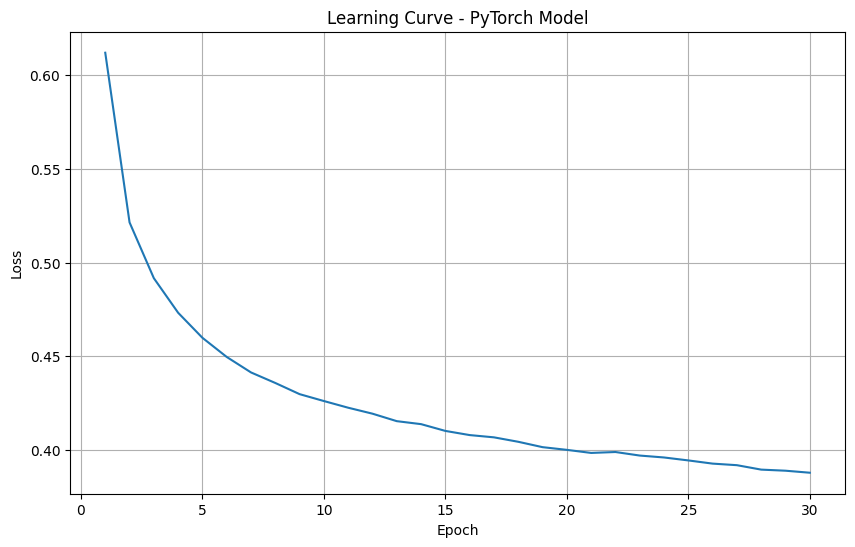

In [11]:
# Plot learning curve untuk model PyTorch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pytorch_losses) + 1), pytorch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - PyTorch Model')
plt.grid(True)
plt.show()

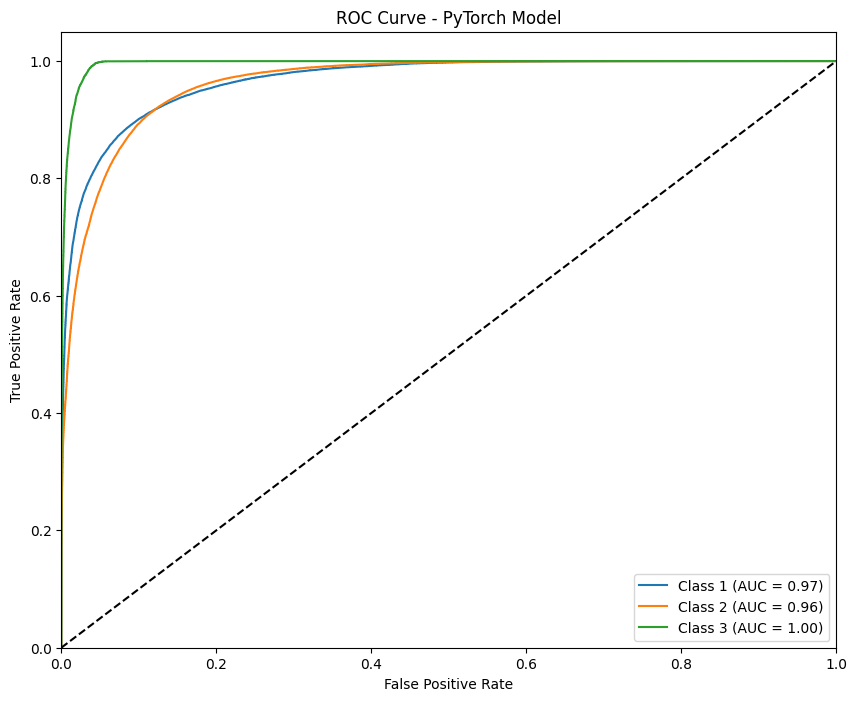

In [12]:
# Plot ROC Curve untuk model PyTorch
plt.figure(figsize=(10, 8))
selected_classes = min(3, num_classes)  # Ambil maksimal 3 kelas saja agar tidak terlalu padat
for i in range(selected_classes):
    plt.plot(fpr_pytorch[i], tpr_pytorch[i],
             label=f'Class {i+1} (AUC = {roc_auc_pytorch[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - PyTorch Model')
plt.legend(loc="lower right")
plt.show()

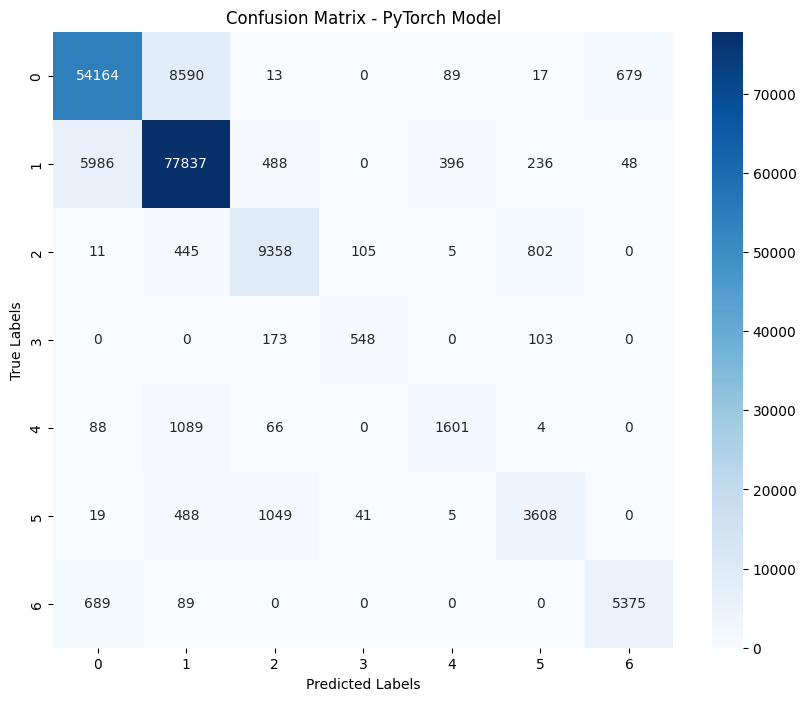

In [13]:
# Confusion Matrix untuk PyTorch
plt.figure(figsize=(10, 8))
cm_pytorch = confusion_matrix(y_test.values, y_pred_pytorch_original)
sns.heatmap(cm_pytorch, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - PyTorch Model')
plt.show()

# Model TensorFlow

## 12. TensorFlow - Definisi Model

In [14]:
# Konversi target ke categorical untuk TensorFlow
y_train_cat = to_categorical(y_train.values - 1, num_classes=num_classes)
y_test_cat = to_categorical(y_test.values - 1, num_classes=num_classes)

def create_tensorflow_model(input_shape, num_classes):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

# Inisialisasi model TensorFlow
model_tensorflow = create_tensorflow_model(X_train.shape[1], num_classes)

# Ringkasan model
print("\nRingkasan Model TensorFlow:")
model_tensorflow.summary()


Ringkasan Model TensorFlow:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           7,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,607 (68.78 KB)

 Trainable params: 17,607 (68.78 KB)

 Non-trainable params: 0 (0.00 B)

## 13. TensorFlow - Pelatihan

In [15]:
# Latih model TensorFlow
print("\nMelatih Model TensorFlow:")
history = model_tensorflow.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Melatih Model TensorFlow:
Epoch 1/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6967 - loss: 0.7195 - val_accuracy: 0.7714 - val_loss: 0.5211
Epoch 2/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7640 - loss: 0.5431 - val_accuracy: 0.8003 - val_loss: 0.4670
Epoch 3/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.7819 - loss: 0.5068 - val_accuracy: 0.8084 - val_loss: 0.4423
Epoch 4/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.7919 - loss: 0.4871 - val_accuracy: 0.8192 - val_loss: 0.4240
Epoch 5/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.7971 - loss: 0.4733 - val_accuracy: 0.8267 - val_loss: 0.4094
Epoch 6/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8028 - loss: 0.4589 - val_accuracy: 0.8341 - val_loss: 0.3947
Epoch 7/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.8077 - loss: 0.4497 - val_accuracy: 0.8397 - val_loss: 0.3859
Epoch 8/30
5084/5084 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step -

## 14. TensorFlow - Evaluasi

In [16]:
# Evaluasi model TensorFlow
y_pred_proba_tensorflow = model_tensorflow.predict(X_test)
y_pred_tensorflow = np.argmax(y_pred_proba_tensorflow, axis=1) + 1  # +1 untuk menyesuaikan kembali ke label asli

# Evaluasi hasil TensorFlow
print("\n--- HASIL EVALUASI MODEL TENSORFLOW ---")
acc_tf, prec_tf, rec_tf, f1_tf, auc_tf, fpr_tf, tpr_tf, roc_auc_tf = calculate_metrics(
    y_test.values, y_pred_tensorflow, y_pred_proba_tensorflow, "TensorFlow"
)

5447/5447 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step

--- HASIL EVALUASI MODEL TENSORFLOW ---

Matriks Evaluasi untuk model TensorFlow:
Akurasi: 0.8716
Presisi (weighted): 0.8724
Recall (weighted): 0.8716
F1-Score (weighted): 0.8705
AUC (rata-rata): 0.9858

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.84      0.87     63552
           2       0.87      0.92      0.90     84991
           3       0.86      0.82      0.84     10726
           4       0.85      0.59      0.69       824
           5       0.77      0.51      0.61      2848
           6       0.68      0.76      0.72      5210
           7       0.92      0.83      0.87      6153

    accuracy                           0.87    174304
   macro avg       0.83      0.75      0.79    174304
weighted avg       0.87      0.87      0.87    174304



## 15. TensorFlow - Visualisasi Hasil

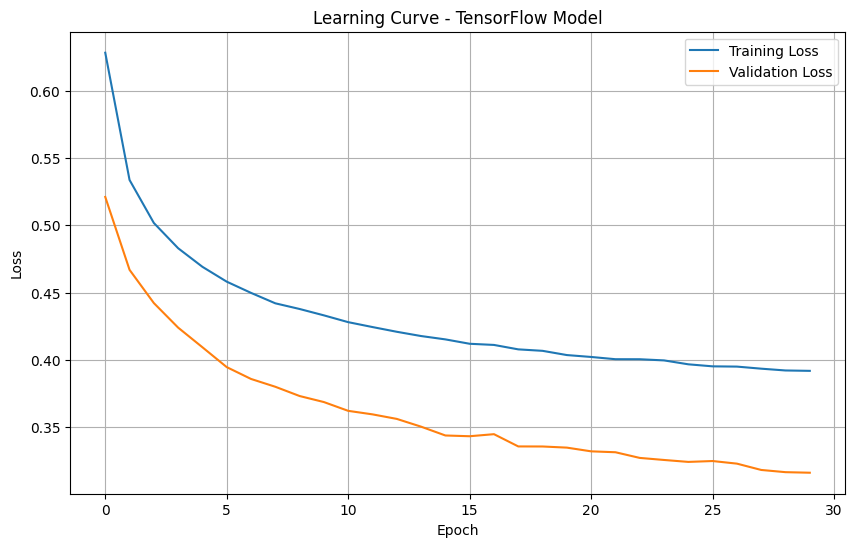

In [17]:
# Plot learning curve untuk model TensorFlow
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve - TensorFlow Model')
plt.legend()
plt.grid(True)
plt.show()

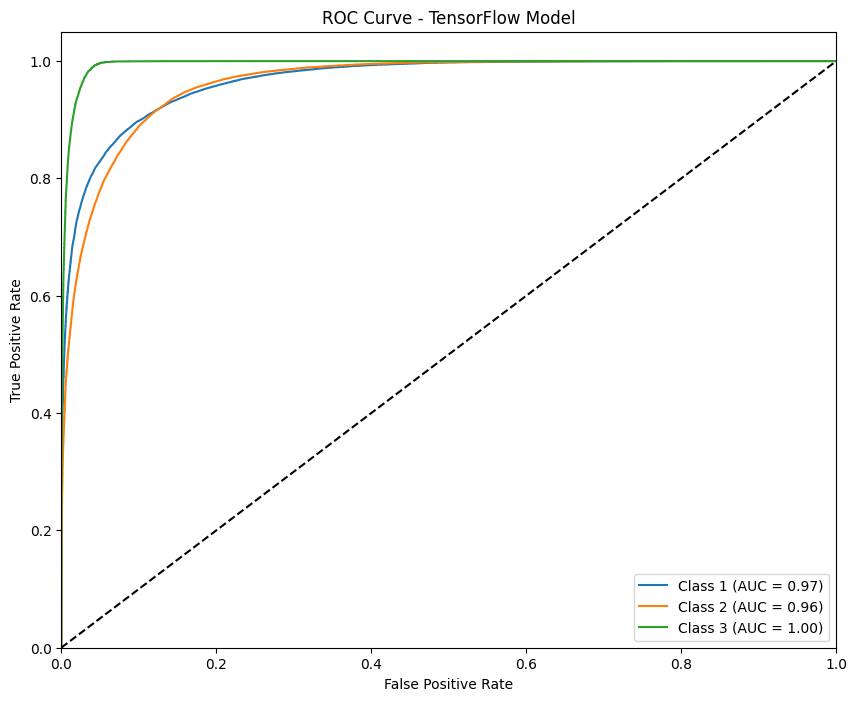

In [18]:
# Plot ROC Curve untuk model TensorFlow
plt.figure(figsize=(10, 8))
selected_classes = min(3, num_classes)  # Ambil maksimal 3 kelas saja agar tidak terlalu padat
for i in range(selected_classes):
    plt.plot(fpr_tf[i], tpr_tf[i],
             label=f'Class {i+1} (AUC = {roc_auc_tf[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - TensorFlow Model')
plt.legend(loc="lower right")
plt.show()

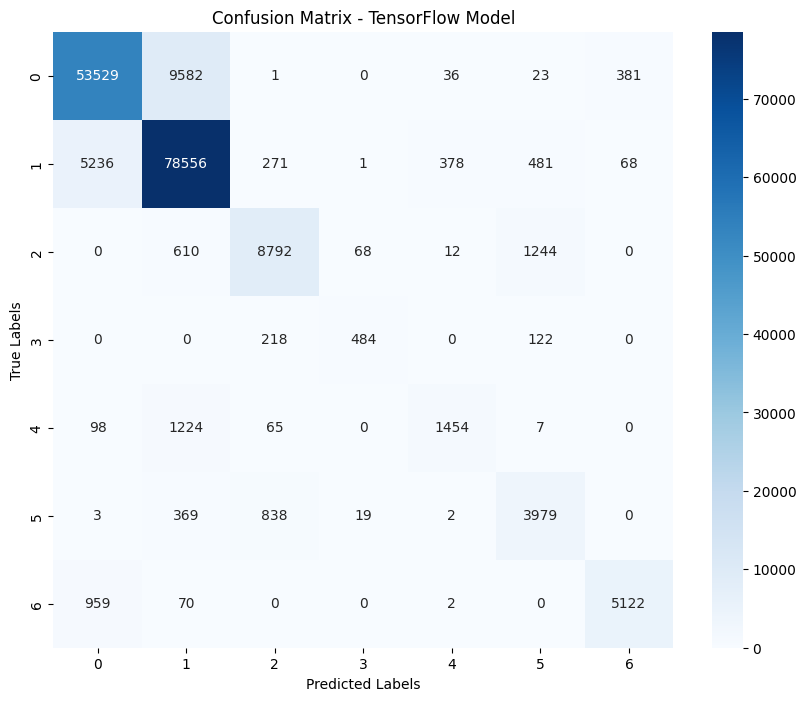

In [19]:
# Confusion Matrix untuk TensorFlow
plt.figure(figsize=(10, 8))
cm_tf = confusion_matrix(y_test.values, y_pred_tensorflow)
sns.heatmap(cm_tf, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - TensorFlow Model')
plt.show()

# Perbandingan Model

In [20]:
# Tampilkan perbandingan metrik dari kedua model
metrics_comparison = pd.DataFrame({
    'Metrik': ['Akurasi', 'Presisi', 'Recall', 'F1-Score', 'AUC'],
    'PyTorch': [acc_pytorch, prec_pytorch, rec_pytorch, f1_pytorch, auc_pytorch],
    'TensorFlow': [acc_tf, prec_tf, rec_tf, f1_tf, auc_tf]
})

print("\nPerbandingan Metrik:")
print(metrics_comparison)


Perbandingan Metrik:
     Metrik   PyTorch  TensorFlow
0   Akurasi  0.874857    0.871558
1   Presisi  0.874219    0.872394
2    Recall  0.874857    0.871558
3  F1-Score  0.873879    0.870540
4       AUC  0.986188    0.985817


# Penjelasan Persamaan Matematika

# Penjelasan Matematika Model Deep Learning MLP

## Matriks Evaluasi

### 1. Akurasi (Accuracy)
**Definisi**: Proporsi prediksi yang benar dari total prediksi.

$$\text{Accuracy} = \frac{\text{Jumlah prediksi benar}}{\text{Total prediksi}} = \frac{TP + TN}{TP + TN + FP + FN}$$

Dimana:
- TP (True Positive): Kasus positif yang diprediksi benar
- TN (True Negative): Kasus negatif yang diprediksi benar
- FP (False Positive): Kasus negatif yang diprediksi sebagai positif (salah)
- FN (False Negative): Kasus positif yang diprediksi sebagai negatif (salah)

### 2. Presisi (Precision)
**Definisi**: Proporsi prediksi positif yang benar-benar positif.

$$\text{Precision} = \frac{TP}{TP + FP}$$

**Multi-kelas (weighted)**:

$$\text{Precision}_{\text{weighted}} = \sum_{i=1}^{k} w_i \times \text{Precision}_i$$

Dimana:
- $w_i$ adalah proporsi sampel kelas $i$ dari total sampel
- $k$ adalah jumlah kelas

### 3. Recall
**Definisi**: Proporsi kasus positif yang berhasil diprediksi sebagai positif.

$$\text{Recall} = \frac{TP}{TP + FN}$$

**Multi-kelas (weighted)**:

$$\text{Recall}_{\text{weighted}} = \sum_{i=1}^{k} w_i \times \text{Recall}_i$$

### 4. F1-Score
**Definisi**: Rata-rata harmonik dari presisi dan recall.

$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2 \times TP}{2 \times TP + FP + FN}$$

**Multi-kelas (weighted)**:

$$\text{F1}_{\text{weighted}} = \sum_{i=1}^{k} w_i \times \text{F1}_i$$

### 5. AUC (Area Under the Curve)
**Definisi**: Area di bawah kurva ROC.

$$\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(t)) \, dt$$

Dimana:
- TPR (True Positive Rate) = Recall = $\frac{TP}{TP + FN}$
- FPR (False Positive Rate) = $\frac{FP}{FP + TN}$

**Multi-kelas (one-vs-rest)**:

$$\text{AUC}_{\text{ovr}} = \frac{1}{k} \sum_{i=1}^{k} \text{AUC}_i$$

### 6. ROC (Receiver Operating Characteristic)
**Definisi**: Kurva yang menghubungkan titik-titik (FPR, TPR) pada berbagai threshold.

## Persamaan Matematika dalam Model

### 1. Fungsi Aktivasi ReLU (Rectified Linear Unit)

$$\text{ReLU}(x) = \max(0, x)$$

**Derivatif**:

$$\text{ReLU}'(x) =
\begin{cases}
1, & \text{jika } x > 0 \\
0, & \text{jika } x \leq 0
\end{cases}$$

### 2. Fungsi Aktivasi Softmax

$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

Dimana:
- $x_i$ adalah output dari neuron ke-$i$
- $n$ adalah jumlah neuron output (kelas)

### 3. Categorical Cross-Entropy Loss

$$\text{CCE} = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$$

Dimana:
- $y_i$ adalah nilai target sebenarnya (0 atau 1 dalam one-hot encoding)
- $\hat{y}_i$ adalah nilai prediksi (probabilitas) dari model

### 4. Forward Pass dalam MLP

**Input layer ke hidden layer pertama**:
$$z^{(1)} = W^{(1)}x + b^{(1)}$$
$$a^{(1)} = \text{ReLU}(z^{(1)})$$

**Hidden layer ke hidden layer**:
$$z^{(l)} = W^{(l)}a^{(l-1)} + b^{(l)}$$
$$a^{(l)} = \text{ReLU}(z^{(l)})$$

**Hidden layer terakhir ke output layer**:
$$z^{(L)} = W^{(L)}a^{(L-1)} + b^{(L)}$$
$$a^{(L)} = \text{Softmax}(z^{(L)})$$

Dimana:
- $x$ adalah input vektor
- $z^{(l)}$ adalah input ke layer $l$
- $a^{(l)}$ adalah output dari layer $l$ setelah aktivasi
- $W^{(l)}$ adalah matriks bobot untuk layer $l$
- $b^{(l)}$ adalah vektor bias untuk layer $l$

### 5. Backpropagation dan Gradient Descent

**Gradient Descent**:
$$w_{t+1} = w_t - \alpha \nabla_w J(w_t)$$

Dimana:
- $w_t$ adalah bobot pada iterasi $t$
- $\alpha$ adalah learning rate
- $\nabla_w J(w_t)$ adalah gradien dari fungsi cost terhadap bobot

### 6. Adam Optimizer

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$w_{t+1} = w_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Dimana:
- $g_t$ adalah gradien pada iterasi $t$
- $m_t$ dan $v_t$ adalah momen pertama dan kedua
- $\beta_1$ dan $\beta_2$ adalah parameter decay rates (biasanya 0.9 dan 0.999)
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik

### 7. Batch Normalization

$$\mu_B = \frac{1}{m}\sum_{i=1}^{m} x_i$$
$$\sigma_B^2 = \frac{1}{m}\sum_{i=1}^{m} (x_i - \mu_B)^2$$
$$\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$
$$y_i = \gamma \hat{x}_i + \beta$$

Dimana:
- $\mu_B$ adalah mean dari batch
- $\sigma_B^2$ adalah varians dari batch
- $\epsilon$ adalah konstanta kecil untuk stabilitas numerik
- $\gamma$ dan $\beta$ adalah parameter yang dipelajari

### 8. Dropout

**Training phase**:
$$r_j \sim \text{Bernoulli}(p)$$
$$\tilde{a}^{(l)} = r \odot a^{(l)}$$

**Inference phase**:
$$a^{(l)} = p \cdot a^{(l)}$$

Dimana:
- $r$ adalah vektor random mask dengan probabilitas $p$ untuk mempertahankan neuron
- $\odot$ adalah perkalian element-wise
- $\tilde{a}^{(l)}$ adalah output setelah dropout